## **1. Importing Libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **2. Loading and Processing Data**

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
x_train.shape, x_test.shape

170500096/170498071 [==============================] - 11s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

10


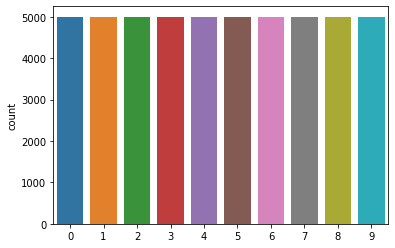

In [3]:

K = len(set(y_train))      ###### Number Of Labels
print(K)
sbn.countplot(y_train)
 

In [4]:
# Spliting X_train Set into training set and validation test
x_train, val_x, y_train, val_y = train_test_split(x_train, y_train, test_size=0.20)

## **3. Some Variables and Traps**

In [5]:
es = EarlyStopping(monitor='loss', patience=12)
filepath="/content/drive/My Drive/Colab Notebooks/Model/bestmodel.h5"
md = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [6]:
# defininig ImageDataGeneratore to increase data
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [7]:
# Important Variables
epochs = 50
batch_size = 32
input_shape = (32, 32, 3)
adam = tf.keras.optimizers.Adam(0.001)

## **4. Building Model with Basic Functional API**

In [29]:


i = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(399, activation='relu')(x)
x = Dropout(0.3)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.3)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)
model.summary()


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)       

In [30]:
# Compiling Model
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Fit Model
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          epochs = epochs,
          validation_data = (val_x, val_y), #datagen.flow(val_x, val_y),
          #callbacks = [es,md],
          shuffle= True
        )

Epoch 1/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.9103 - accuracy: 0.3067 - val_loss: 1.5312 - val_accuracy: 0.4498
Epoch 2/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.4675 - accuracy: 0.4709 - val_loss: 1.2077 - val_accuracy: 0.5639
Epoch 3/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.2508 - accuracy: 0.5574 - val_loss: 1.1276 - val_accuracy: 0.6127
Epoch 4/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.0838 - accuracy: 0.6240 - val_loss: 0.9331 - val_accuracy: 0.6747
Epoch 5/50
1250/1250 [==============================] - 22s 17ms/step - loss: 0.9841 - accuracy: 0.6663 - val_loss: 1.1647 - val_accuracy: 0.6166
Epoch 6/50
1250/1250 [==============================] - 21s 17ms/step - loss: 0.8935 - accuracy: 0.6986 - val_loss: 0.8323 - val_accuracy: 0.7153
Epoch 7/50
1250/1250 [==============================] - 21s 17ms/step - loss: 0.8250 - accuracy: 0.7197 - val_loss: 0.8721 -

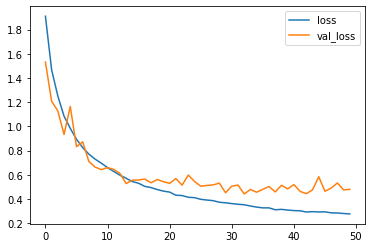

In [32]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(History.history['loss'], label='loss')
plt.plot(History.history['val_loss'], label='val_loss')
plt.legend()

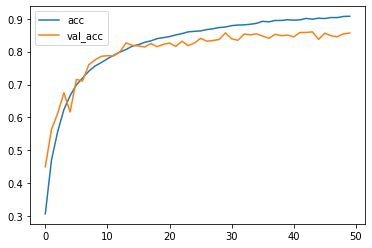

In [33]:
# Plot accuracy per iteration
plt.plot(History.history['accuracy'], label='acc')
plt.plot(History.history['val_accuracy'], label='val_acc')
plt.legend()

## **5. Loading Model and Making Prediction**

In [34]:
model1 = load_model(filepath)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)       

[[885  13  26   5   5   4   9   6  38   9]
 [ 13 940   0   0   0   1   2   1   8  35]
 [ 54   1 691  23  39  43 105  21  12  11]
 [ 37  11  42 542  33 114 148  32  22  19]
 [ 18   3  41  20 733  26  99  47   7   6]
 [  8   4  16  66  24 750  67  49   8   8]
 [  5   0   9   7   5   1 964   3   5   1]
 [ 12   0  14  10  16  31  23 884   4   6]
 [ 55  13   4   1   1   0   4   3 901  18]
 [ 31  55   1   2   1   0   3   3  11 893]]


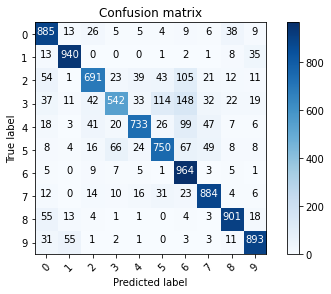

In [35]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model1.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))